# Burst Detection and Visualization

 The main objectives are:
 - To identify spikes (action potentials) from the membrane potential trace.
 - To group spikes into bursts based on interspike interval (ISI) thresholds.
 - To visualize the waveform of each detected burst and the spikes that compose it.

- **Import Libraries**

 These libraries handle data loading, numerical computation, signal analysis, and plotting.

In [1]:
import pyabf                        # For reading Axon Binary Files (.abf)
import numpy as np                  # Numerical computations
import matplotlib.pyplot as plt     # Visualization
from scipy.signal import find_peaks # Spike detection via peak finding
%matplotlib widget   

- **Load ABF Data**

The following block loads the specified `.abf` file, which may contain multiple sweeps.
Each sweep corresponds to one recorded trace (voltage vs. time).

In [2]:
file_path = "bursting/cell89basal.abf"  # Path to the electrophysiological recording
abf = pyabf.ABF(file_path)              # Load ABF object

# Concatenate all Sweeps
# Many recordings contain several sweeps (repetitions of the same experiment).
# Merge them into one continuous signal for simplicity.
signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])

# Compute the sampling interval and construct a time vector
dt = 1.0 / abf.dataRate
time = np.arange(len(signal)) * dt

print(f"Loaded file: {file_path}")
print(f"Total duration: {time[-1]:.2f} s | Sweeps: {abf.sweepCount}")

Loaded file: bursting/cell89basal.abf
Total duration: 645.00 s | Sweeps: 30


- **Spike Detection**

Spikes (action potentials) are identified by finding local maxima above a voltage threshold.
The `find_peaks` function returns the indices of detected peaks.

In [3]:
threshold = -35  # mV threshold for spike detection
spike_indices, _ = find_peaks(signal, height=threshold)
spike_times = time[spike_indices]  # Convert indices to time stamps

print(f"Detected {len(spike_times)} spikes.")

Detected 4275 spikes.


- **Burst Detection**

A burst is a sequence of spikes occurring in rapid succession.
Here, bursts are defined by the interspike interval (ISI): if the time gap between two spikes
is smaller than `burst_threshold`, they belong to the same burst.

In [4]:
isi = np.diff(spike_times)     # Compute interspike intervals
burst_threshold = 0.3          # ISI threshold in seconds

bursts = []                    # Will hold lists of spike times for each burst
current_burst = [spike_times[0]]

# Iterate through all ISIs and group spikes into bursts
for i in range(1, len(isi)):
    if isi[i-1] < burst_threshold:
        # Continue current burst
        current_burst.append(spike_times[i])
    else:
        # If gap exceeds threshold, the burst ends
        if len(current_burst) > 1:
            bursts.append(current_burst)
        current_burst = [spike_times[i]]

# Add the last burst if valid
if len(current_burst) > 1:
    bursts.append(current_burst)

print(f"Total detected bursts: {len(bursts)}")

Total detected bursts: 277


- **Burst Visualization**

10 detected bursts are ploted, each in a separate figure.
Each plot shows:
 - The voltage trace for the burst window.
 - The spike peaks in red.
 - A connecting line between spikes for visual clarity.

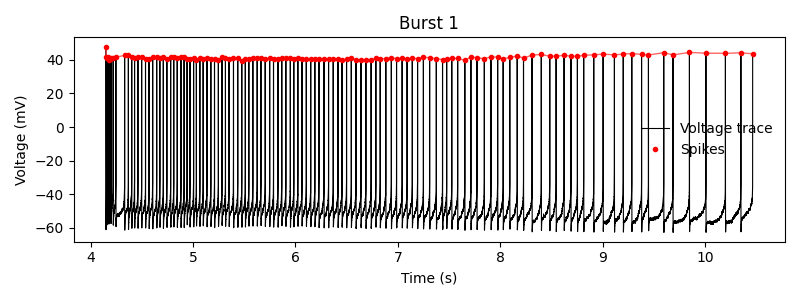

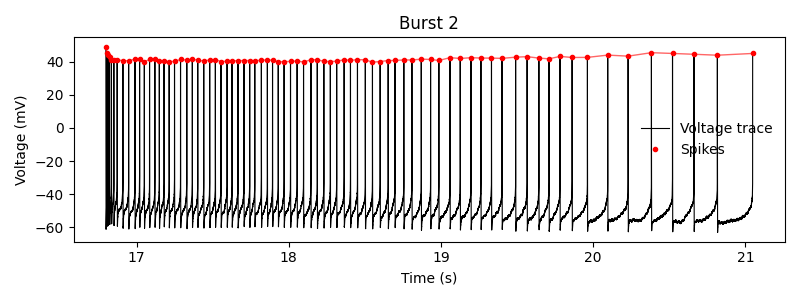

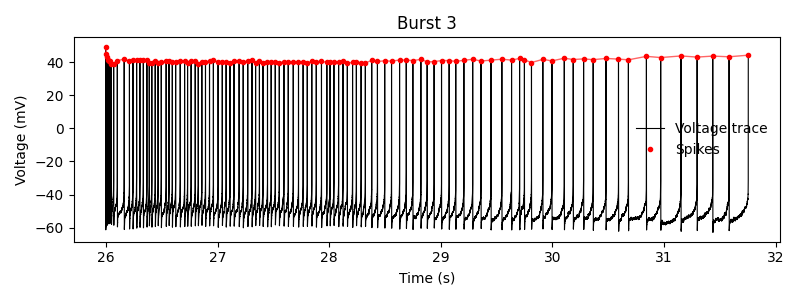

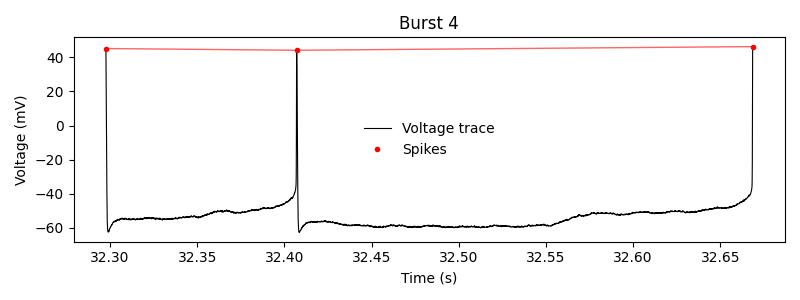

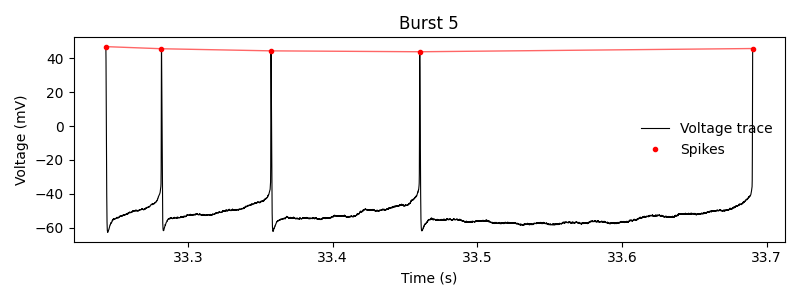

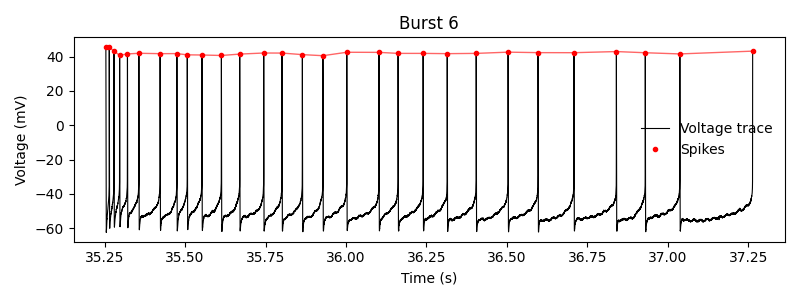

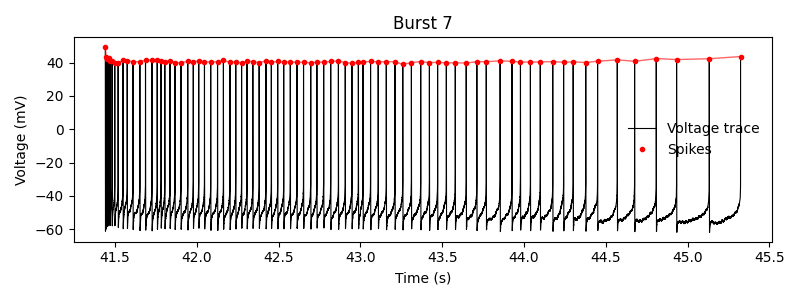

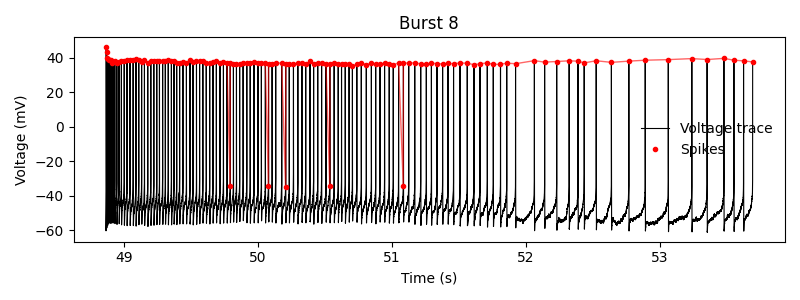

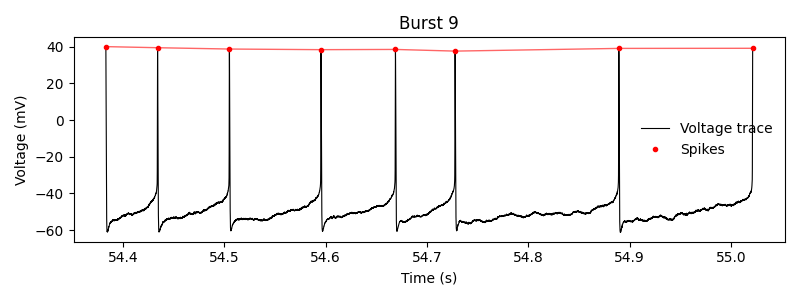

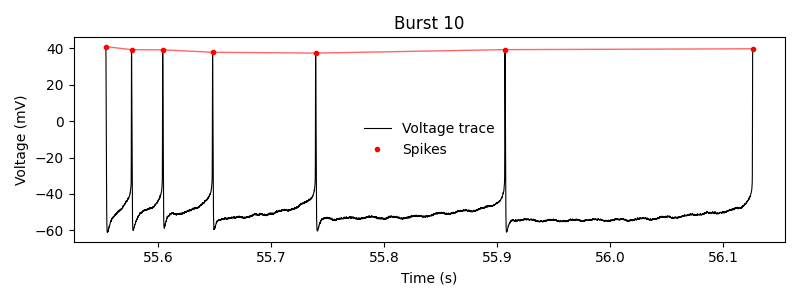

In [5]:
n_bursts_to_plot = min(10, len(bursts))  # Plot only up to 10 bursts

for i in range(n_bursts_to_plot):
    burst = bursts[i]

    # Create a mask to extract the segment of the trace corresponding to this burst
    mask = (time >= burst[0]) & (time <= burst[-1])
    t_burst = time[mask]
    s_burst = signal[mask]

    # Identify which spikes fall within the burst window
    burst_peak_mask = (spike_times >= burst[0]) & (spike_times <= burst[-1])
    burst_spike_times = spike_times[burst_peak_mask]
    burst_spike_values = signal[spike_indices][burst_peak_mask]

    # Create and configure the figure
    plt.figure(figsize=(8, 3))
    plt.plot(t_burst, s_burst, lw=0.8, color="black", label="Voltage trace")
    plt.plot(burst_spike_times, burst_spike_values, "ro", markersize=3, label="Spikes")
    plt.plot(burst_spike_times, burst_spike_values, "r-", lw=1, alpha=0.6)

    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.title(f"Burst {i+1}")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

# Normalization and Visualization of Bursts

This section builds upon the previous burst detection pipeline.
After identifying bursts, it is normalized their amplitude and duration 
to allow for shape comparison between bursts of different lengths and sizes.

- **What is done:**

- Detect spikes and bursts from an electrophysiological recording.
- Normalize each burst’s waveform in both amplitude (Y-axis) and duration (X-axis).
- Visualize the normalized waveforms to analyze burst morphology.


- **Import Required Libraries**

In [6]:
import pyabf                        # For reading ABF (Axon Binary Format) files
import numpy as np                  # Numerical operations
import matplotlib.pyplot as plt     # Plotting library
from scipy.signal import find_peaks # For spike detection
from scipy.interpolate import interp1d  # For rescaling burst duration via interpolation

- **Load and Concatenate ABF Data**

The `.abf` file may contain several sweeps. Each sweep represents a segment 
of the same recording, so it can be concatenated them into a single continuous signal.

In [7]:
file_path = "bursting/cell89basal.abf"  # Path to the electrophysiological recording
abf = pyabf.ABF(file_path)              # Load ABF file

# Concatenate all sweeps into one continuous array
signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])

# Compute the time step (dt) and generate the corresponding time vector
dt = 1.0 / abf.dataRate
time = np.arange(len(signal)) * dt

print(f"Loaded: {file_path}")
print(f"Total duration: {time[-1]:.2f} s | Sweeps: {abf.sweepCount}")

Loaded: bursting/cell89basal.abf
Total duration: 645.00 s | Sweeps: 30


- **Spike Detection**

Spikes (action potentials) are detected by locating peaks above a voltage threshold.
Here, the `find_peaks` function identifies all local maxima above -35 mV.

In [8]:
threshold = -35  # Spike detection threshold in millivolts
spike_indices, _ = find_peaks(signal, height=threshold)
spike_times = time[spike_indices]  # Convert indices to time

print(f"Detected {len(spike_times)} spikes.")

Detected 4275 spikes.


- **Burst Detection**

 Bursts are groups of spikes occurring close together in time.
 Interspike intervals (ISIs) and group spikes are computed when 
 consecutive ISIs are below a set threshold (0.3 seconds here).

In [9]:
isi = np.diff(spike_times)
burst_threshold = 0.3  # seconds

bursts = []
current_burst = [spike_times[0]]

# Group spikes based on ISI threshold
for i in range(1, len(isi)):
    if isi[i-1] < burst_threshold:
        current_burst.append(spike_times[i])
    else:
        if len(current_burst) > 1:
            bursts.append(current_burst)
        current_burst = [spike_times[i]]

# Include the final burst if valid
if len(current_burst) > 1:
    bursts.append(current_burst)

print(f"Total detected bursts: {len(bursts)}")

Total detected bursts: 277


- **Define Normalization Functions**

To compare burst shapes, they are normalized them in two dimensions:
 
 - **Y-normalization:** Standardize amplitude via z-score normalization:
   \[
   y' = \frac{y - \text{mean}(y)}{\text{std}(y)}
   \]
   This centers the waveform at 0 and scales it by its standard deviation.

 - **X-rescaling:** Interpolate each burst waveform to a fixed number of points
   (e.g., 100), effectively normalizing its duration.

In [10]:
def normalize_y(signal_segment):
    #Normalize amplitude using z-score normalization.
   
    return (signal_segment - np.mean(signal_segment)) / np.std(signal_segment)


def rescale_x(time_segment, signal_segment, n_points=100):
    #Rescale the burst duration by interpolating the signal to a fixed number of samples (n_points).
    
    f = interp1d(np.linspace(0, 1, len(signal_segment)), signal_segment)
    return f(np.linspace(0, 1, n_points))

- **Plot Normalized Bursts**

The first 10 detected bursts are plotted. Each burst is:
 1. Cropped from the original signal.
 2. Rescaled in duration (X-axis).
 3. Normalized in amplitude (Y-axis).
 
 This enables direct visual comparison of waveform shapes 
 across bursts that originally had different durations and amplitudes.

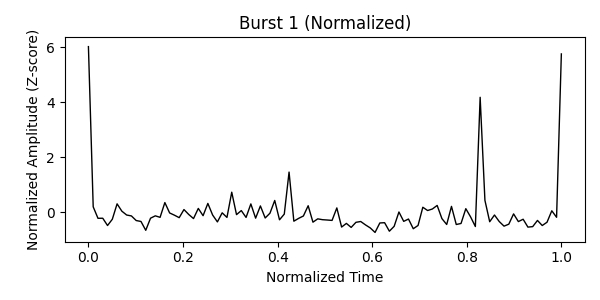

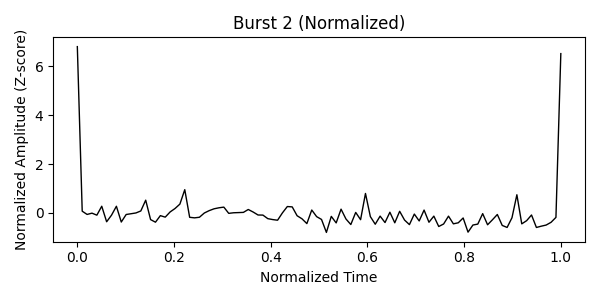

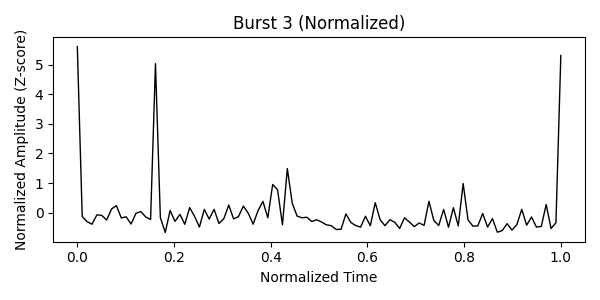

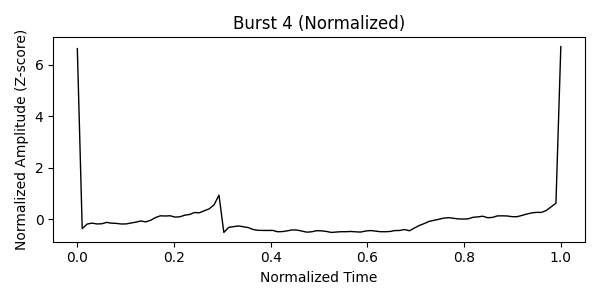

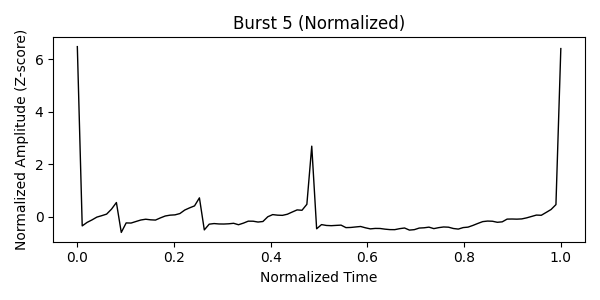

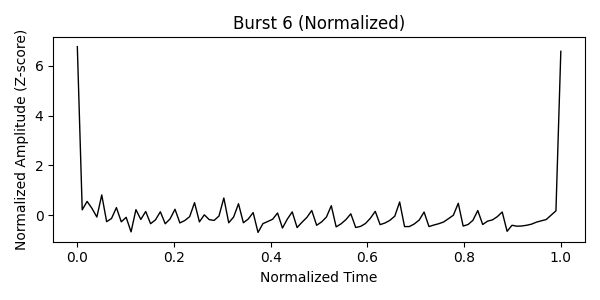

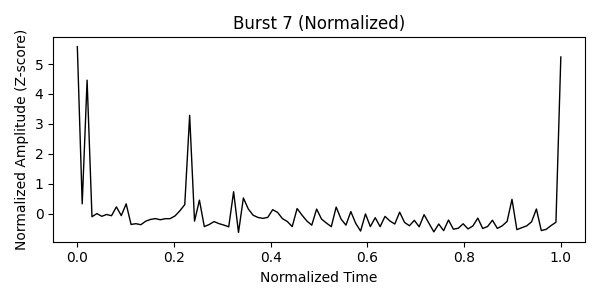

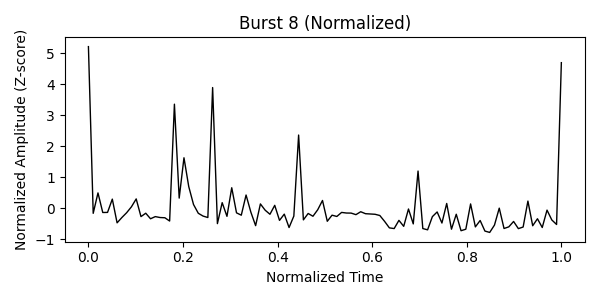

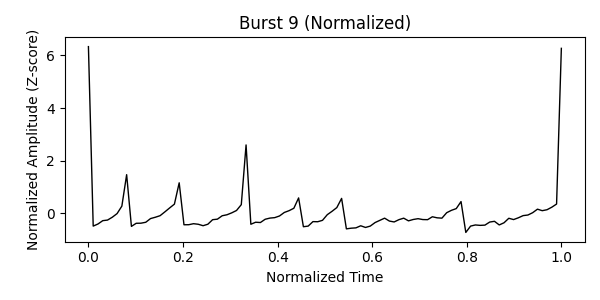

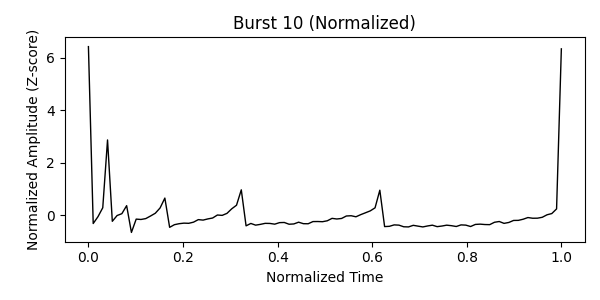

In [11]:
n_bursts_to_plot = min(10, len(bursts))

for i in range(n_bursts_to_plot):
    burst = bursts[i]

    # Extract the burst segment from the full signal
    mask = (time >= burst[0]) & (time <= burst[-1])
    t_burst = time[mask]
    s_burst = signal[mask]

    # Normalize duration and amplitude
    s_rescaled = rescale_x(t_burst, s_burst, n_points=100)
    s_normalized = normalize_y(s_rescaled)

    # Plot the normalized burst
    plt.figure(figsize=(6, 3))
    plt.plot(np.linspace(0, 1, 100), s_normalized, "k-", lw=1)
    plt.title(f"Burst {i+1} (Normalized)")
    plt.xlabel("Normalized Time")
    plt.ylabel("Normalized Amplitude (Z-score)")
    plt.tight_layout()
    plt.show()

# Burst Classification and Normalization for Shape Comparison

 This section extends the previous burst detection pipeline to:
 1. **Classify bursts** based on their shape (Square Wave, Parabolic, or Other).
 2. **Normalize** the detected bursts in amplitude and duration.
 3. **Overlay** multiple normalized bursts of each type for visual comparison.
 

-**Main idea:**

 - Square-wave bursts: Have relatively flat plateaus (min voltage higher than surrounding baseline).
 - Parabolic bursts: Have deep, curved troughs (min voltage lower than baseline).
 - Other bursts: Do not fit neatly into these categories.


- **Import Required Libraries**

In [12]:
import pyabf                         # Read ABF files (Axon Binary Format)
import numpy as np                   # Numerical computations
import matplotlib.pyplot as plt      # Plotting
from scipy.signal import find_peaks  # Spike detection
from scipy.interpolate import interp1d  # Duration normalization via interpolation

- **Load and Concatenate ABF Data**

Load the electrophysiological recording and merge all sweeps into one continuous signal.

In [13]:
file_path = "bursting/cell89basal.abf"  # Path to ABF recording
abf = pyabf.ABF(file_path)

# Concatenate all sweeps
signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])

# Define time vector
dt = 1.0 / abf.dataRate
time = np.arange(len(signal)) * dt

print(f"Loaded file: {file_path}")
print(f"Total duration: {time[-1]:.2f} s | Sampling rate: {abf.dataRate} Hz")

Loaded file: bursting/cell89basal.abf
Total duration: 645.00 s | Sampling rate: 10000 Hz


- **Spike Detection**

Detect action potentials (spikes) by locating peaks above a voltage threshold.
Here, a threshold of -35 mV is used to identify spikes.

In [14]:
threshold = -35  # Spike detection threshold (mV)
spike_indices, _ = find_peaks(signal, height=threshold)
spike_times = time[spike_indices]

print(f"Detected {len(spike_times)} spikes.")

Detected 4275 spikes.


- **Burst Detection**

Bursts are sequences of spikes separated by short interspike intervals (ISIs).
 
 - Compute ISIs using the time difference between consecutive spikes.
 - Group spikes into bursts when ISI < 0.3 s.
 - Each burst is represented by its start and end times.

In [15]:
isi = np.diff(spike_times)
burst_threshold = 0.3  # seconds

bursts = []
current_burst = [spike_times[0]]

for i in range(1, len(isi)):
    if isi[i-1] < burst_threshold:
        current_burst.append(spike_times[i])
    else:
        if len(current_burst) > 1:
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]

# Add last burst if valid
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))

print(f"Total detected bursts: {len(bursts)}")

Total detected bursts: 277


Burst Classification
 
Each burst is classified into one of three categories:
 
 - **Square Wave**: The minimum voltage within the burst is higher than the mean voltage 
   of the interburst regions → indicates a flattened plateau shape.
 - **Parabolic**: The minimum voltage is *lower* than the mean interburst voltage → 
   suggests a concave, parabolic waveform.
 - **Other**: Bursts that do not clearly fit either profile.
 
 Classification is based on comparing the burst minimum (`burst_min`) with the 
 mean voltage of neighboring intervals (before and after the burst).

In [16]:
square_wave_bursts = []
parabolic_bursts = []
other_bursts = []

for i, (burst_start, burst_end) in enumerate(bursts):
    # Voltage segment of the burst
    burst_mask = (time >= burst_start) & (time <= burst_end)
    burst_min = np.min(signal[burst_mask])

    # Estimate baseline (interburst mean)
    prev_mean = np.mean(signal[(time > bursts[i-1][1]) & (time < burst_start)]) if i > 0 else np.nan
    next_mean = np.mean(signal[(time > burst_end) & (time < bursts[i+1][0])]) if i < len(bursts)-1 else np.nan
    inter_mean = np.nanmean([prev_mean, next_mean])

    # Classification based on comparison
    if burst_min > inter_mean:
        square_wave_bursts.append((burst_start, burst_end))
    elif burst_min < inter_mean:
        parabolic_bursts.append((burst_start, burst_end))
    else:
        other_bursts.append((burst_start, burst_end))

print(f"Square Wave bursts: {len(square_wave_bursts)}")
print(f"Parabolic bursts: {len(parabolic_bursts)}")
print(f"Other bursts: {len(other_bursts)}")

Square Wave bursts: 88
Parabolic bursts: 189
Other bursts: 0


- **Normalization Functions**

Before comparing bursts visually, normalize:
 
 - **Y-axis (Amplitude):** via z-score normalization → mean = 0, std = 1.
 - **X-axis (Duration):** via interpolation → each burst is resampled to a fixed number of points (e.g., 100).

In [17]:
def normalize_y(signal_segment):
    # Normalize amplitude (z-score): center and scale.
    
    return (signal_segment - np.mean(signal_segment)) / np.std(signal_segment)

def rescale_x(time_segment, signal_segment, n_points=100):
    # Normalize duration by interpolating to n_points evenly spaced samples.
    
    f = interp1d(np.linspace(0, 1, len(signal_segment)), signal_segment)
    return f(np.linspace(0, 1, n_points))

- **Overlay Normalized Bursts**

This helper function overlays multiple bursts of the same type, 
showing how similar or different their shapes are once normalized.
 
 Parameters:
 - `burst_list`: list of (start, end) tuples for each burst
 - `burst_type`: string label for the burst type
 - `n`: number of bursts to plot (default = 3)

In [18]:
def overlay_bursts(burst_list, burst_type, n=3):
    if len(burst_list) == 0:
        print(f"No bursts of type {burst_type} to plot.")
        return

    n_to_plot = min(n, len(burst_list))
    plt.figure(figsize=(6, 3))
    
    for i in range(n_to_plot):
        start, end = burst_list[i]
        mask = (time >= start) & (time <= end)
        t_burst = time[mask]
        s_burst = signal[mask]

        # Normalize in both time and amplitude
        s_rescaled = rescale_x(t_burst, s_burst, n_points=100)
        s_normalized = normalize_y(s_rescaled)

        plt.plot(np.linspace(0, 1, 100), s_normalized, lw=1, alpha=0.7, label=f'Burst {i+1}')

    plt.title(f"{burst_type} Bursts Overlay (Normalized)")
    plt.xlabel("Normalized Time")
    plt.ylabel("Normalized Amplitude (Z-score)")
    plt.legend()
    plt.tight_layout()
    plt.show()

- **Visualize Burst Types**

 Overlay up to three normalized bursts for each type to visually compare 
 their characteristic waveform shapes.

C:\Users\manur\AppData\Local\Temp\ipykernel_20112\372583814.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 3))


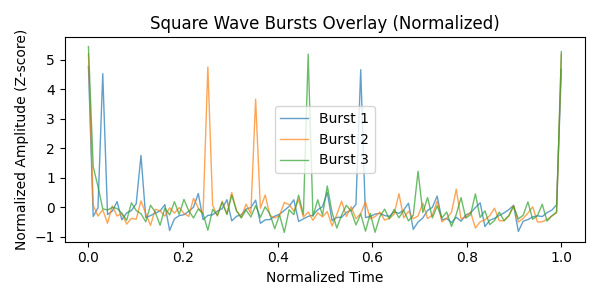

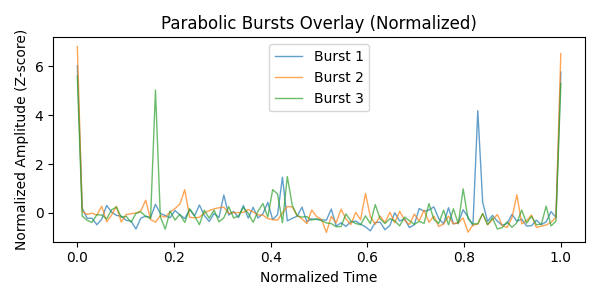

No bursts of type Other to plot.


In [19]:


overlay_bursts(square_wave_bursts, "Square Wave", n=3)
overlay_bursts(parabolic_bursts, "Parabolic", n=3)
overlay_bursts(other_bursts, "Other", n=3)


# Burst Detection and Classification Pipeline

 This section processes electrophysiological recordings to **detect**, **classify**, and **normalize** neuronal bursts.
 The goal is to convert raw intracellular signals into standardized representations suitable for analysis or
 machine learning (e.g., shapelet extraction).
 
 The workflow includes:
 1. **Signal loading:** Reads `.abf` recordings and concatenates sweeps into one trace.  
 2. **Spike detection:** Identifies action potentials using a simple amplitude threshold.  
 3. **Burst detection:** Groups spikes separated by short inter-spike intervals (ISIs).  
 4. **Burst classification:** Compares each burst’s minimum voltage to its baseline to label it as square-wave, parabolic, or other.  
 5. **Normalization:** Rescales burst duration and amplitude for uniform analysis.  

In [20]:
import pyabf
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


- **Preprocessing Functions**

 These utility functions prepare and normalize the data before analysis.  
 They handle signal scaling, time normalization, and core feature extraction steps.

In [21]:
def normalize_y(signal_segment):
    # Normalize the amplitude of a signal segment using z-score.
    # Removes DC offsets and scales variance to 1, allowing bursts from different
    # cells or sweeps to be directly compared in terms of *shape*, not amplitude.
    return (signal_segment - np.mean(signal_segment)) / np.std(signal_segment)

def rescale_x(time_segment, signal_segment, n_points=100):
    # Rescale (interpolate) a burst in time to a fixed number of points.
    # This operation makes all bursts the same length, regardless of duration.
    # Useful for averaging or machine learning input consistency.
    f = interp1d(np.linspace(0, 1, len(signal_segment)), signal_segment)
    return f(np.linspace(0, 1, n_points))


- **Spike and Burst Detection**

 Here are defined functions to detect action potentials (spikes) and to group
 them into bursts based on inter-spike intervals.
 
 The logic:
 - **Spikes** are detected using a simple amplitude threshold.
 - **Bursts** are defined as sequences of spikes where consecutive spikes
   occur within a short temporal window (e.g. 300 ms).

In [22]:
def detect_spikes(signal, threshold=-35):
    # Find all local maxima above the given voltage threshold.
    # 'find_peaks' returns indices of peaks that exceed the specified height.
    spike_indices, _ = find_peaks(signal, height=threshold)
    return spike_indices

def detect_bursts(spike_times, burst_threshold=0.3):
    # Group detected spikes into bursts using inter-spike intervals (ISIs).
    # If the ISI between two spikes is less than 'burst_threshold',
    # they are considered part of the same burst.
    isi = np.diff(spike_times)
    bursts = []
    current_burst = [spike_times[0]]
    
    for i in range(1, len(isi)):
        if isi[i-1] < burst_threshold:
            current_burst.append(spike_times[i])
        else:
            # Save only bursts with more than one spike
            if len(current_burst) > 1:
                bursts.append((current_burst[0], current_burst[-1]))
            current_burst = [spike_times[i]]
    
    # Handle the last burst (if any)
    if len(current_burst) > 1:
        bursts.append((current_burst[0], current_burst[-1]))
    
    return bursts

- **Burst Classification**

 Once bursts are detected, they are categorized based on their waveform morphology.
 
 The classification rule compares the **minimum voltage inside the burst** to
 the **mean voltage between bursts**:
 
 - **Square-wave bursts:** Baseline-like minimum (flat, plateau depolarization).  
 - **Parabolic bursts:** Deep hyperpolarization (concave, parabolic-shaped trough).  
 - **Other:** Neither clearly square nor parabolic.  

In [23]:
def classify_bursts(bursts, signal, time):    
    # Initialize lists to store classified bursts.
    square_wave_bursts = []
    parabolic_bursts = []
    other_bursts = []

    for i, (burst_start, burst_end) in enumerate(bursts):
        burst_mask = (time >= burst_start) & (time <= burst_end)
        burst_min = np.min(signal[burst_mask])  # Minimum voltage during burst

        # Estimate the mean voltage of regions before and after the burst
        prev_mean = np.mean(signal[(time > bursts[i-1][1]) & (time < burst_start)]) if i > 0 else np.nan
        next_mean = np.mean(signal[(time > burst_end) & (time < bursts[i+1][0])]) if i < len(bursts)-1 else np.nan
        inter_mean = np.nanmean([prev_mean, next_mean])  # Average interburst voltage
        
        # Classification rule based on voltage morphology
        if burst_min > inter_mean:
            square_wave_bursts.append((burst_start, burst_end))
        elif burst_min < inter_mean:
            parabolic_bursts.append((burst_start, burst_end))
        else:
            other_bursts.append((burst_start, burst_end))

    return square_wave_bursts, parabolic_bursts, other_bursts

- **Burst Normalization for Machine Learning**

 This function extracts the waveform of each burst and standardizes it:
 - **Rescale in time** (to the same number of points)  
 - **Normalize in amplitude** (z-score)  
 
 The result is a set of comparable waveforms ready for downstream analyses
 such as clustering, shapelet learning, or classification.

In [24]:
def extract_normalized_bursts(burst_list, signal, time, n_points=100):
    normalized_bursts = []
    for start, end in burst_list:
        mask = (time >= start) & (time <= end)
        t_burst = time[mask]
        s_burst = signal[mask]

        # Step 1: Equalize duration
        s_rescaled = rescale_x(t_burst, s_burst, n_points=n_points)
        # Step 2: Normalize amplitude
        s_normalized = normalize_y(s_rescaled)

        normalized_bursts.append(s_normalized)
    return normalized_bursts

- **Load and Process the Electrophysiological Signal**

 What is done:
 1. Load `.abf` data and concatenate all sweeps into one continuous signal.  
 2. Compute the time vector based on the sampling rate.  
 3. Detect spikes, then identify bursts.  
 4. Classify bursts morphologically.  
 5. Normalize and prepare them for downstream analysis.

In [25]:
# Load the signal 
file_path = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path)

# Concatenate all sweeps into one continuous trace
signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])
dt = 1.0 / abf.dataRate  # Sampling interval (s)
time = np.arange(len(signal)) * dt  # Time vector

# Detect spikes and bursts
spike_indices = detect_spikes(signal)       # Find peaks above threshold
spike_times = time[spike_indices]           # Convert indices to time
bursts = detect_bursts(spike_times)         # Group spikes into bursts

# Classify bursts by morphology
square_wave_bursts, parabolic_bursts, other_bursts = classify_bursts(bursts, signal, time)

# Extract normalized burst waveforms for comparative or ML analysis
n_points = 100
square_bursts_normalized = extract_normalized_bursts(square_wave_bursts, signal, time, n_points)
parabolic_bursts_normalized = extract_normalized_bursts(parabolic_bursts, signal, time, n_points)
other_bursts_normalized = extract_normalized_bursts(other_bursts, signal, time, n_points)

# Combine all normalized bursts into a single dataset and create label array
all_normalized_bursts = (
    square_bursts_normalized + 
    parabolic_bursts_normalized + 
    other_bursts_normalized
)

labels = (
    [0]*len(square_bursts_normalized) +    # 0 = Square Wave
    [1]*len(parabolic_bursts_normalized) + # 1 = Parabolic
    [2]*len(other_bursts_normalized)       # 2 = Other
)

- **Shapelet Learning on Normalized Bursts**
 
 This section applies **time-series shapelet learning** to the normalized bursts dataset generated previously.
 The goal is to learn **discriminative subsequences (shapelets)** that separate burst classes (Square Wave, Parabolic, Other).
 
 Workflow:
 1. **Prepare input data**: convert to 3D time-series format and normalize to [0,1].  
 2. **Configure shapelet model**: define number and size of shapelets, regularization, and optimizer.  
 3. **Train the model**: learn the shapelets that best separate the classes.  
 4. **Transform bursts into distance space**: represent each burst by its distance to learned shapelets.  
 5. **Visualize results**: plot learned shapelets and 2D distance space with decision boundaries.

- **Imports**

  `numpy` and `matplotlib` for numerical operations and plotting.  
  `tslearn.preprocessing` to normalize time-series data.  
  `tslearn.shapelets` to learn discriminative shapelets from time-series.  
  `tensorflow.keras.optimizers.Adam` for gradient-based optimization during training.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets
from tensorflow.keras.optimizers import Adam

- **Prepare Input Data**

 `all_normalized_bursts` and `labels` come from the previous burst detection pipeline.  
 Shapelet learning expects **3D time-series arrays** of shape `(n_samples, time_series_length, 1)`.  
 Normalize each burst to [0,1] to ensure comparable amplitude across bursts.

In [27]:
# Convert to 3D array for tslearn (n_samples, time_series_length, 1)
X = np.array(all_normalized_bursts)[:, :, np.newaxis]
y = np.array(labels)

# Normalize each time series to [0,1] for shapelet learning
X = TimeSeriesScalerMinMax().fit_transform(X)

- **Shapelet Model Configuration**

 Parameters:
  `n_shapelets_per_size`: number of shapelets for each length (here, equal to burst length).  
  `weight_regularizer`: L2 regularization to prevent overfitting.  
  `optimizer`: Adam optimizer with learning rate 0.01.  
  `max_iter`: maximum number of training iterations.  
  `scale=False`: shapelets are not automatically scaled.  
  `random_state`: for reproducibility.

In [28]:
n_shapelets_per_size = {X.shape[1]: 2}  # 2 shapelets per burst length

shp_clf = LearningShapelets(
    n_shapelets_per_size=n_shapelets_per_size,
    weight_regularizer=0.0001,
    optimizer=Adam(0.01),
    max_iter=300,
    verbose=0,
    scale=False,
    random_state=42
)

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\tslearn\shapelets\shapelets.py:353: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


- **Train Shapelet Model**

 Fit the model to the normalized bursts and their labels.  
 The model learns shapelets that minimize classification loss while remaining interpretable as short subsequences.

In [29]:
shp_clf.fit(X, y)  # Learn shapelets from bursts

LearningShapelets(max_iter=300, n_shapelets_per_size={100: 2},
                  optimizer=<keras.src.optimizers.adam.Adam object at 0x0000014D36F496A0>,
                  random_state=42, weight_regularizer=0.0001)

- **Transform Bursts to Distance Space**
 
 Each burst is represented by its distance to each learned shapelet.
 For 2 shapelets, this yields a **2D feature space**, suitable for visualization or further classification.

In [30]:
distances = shp_clf.transform(X).reshape((-1, 2))  # 2 shapelets → 2D coordinates

- **Visualization Setup**
 
  `viridis` colormap for plotting classes.  
  GridSpec layout: two shapelet plots on top, 2D distance scatter plot on the right.

C:\Users\manur\AppData\Local\Temp\ipykernel_20112\2252988568.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', 4)


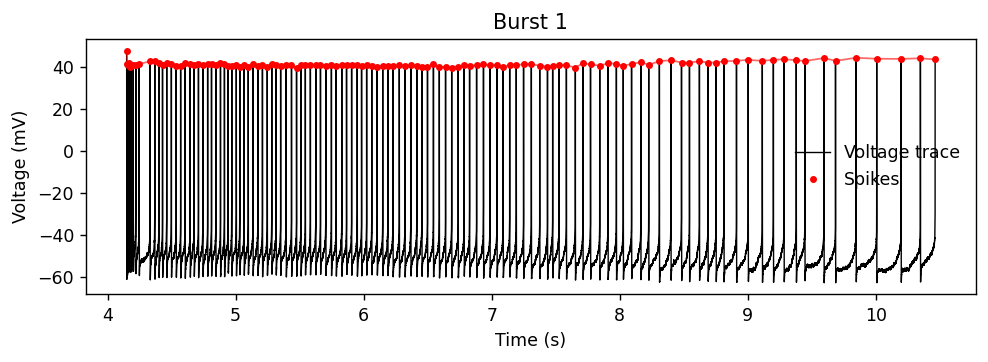

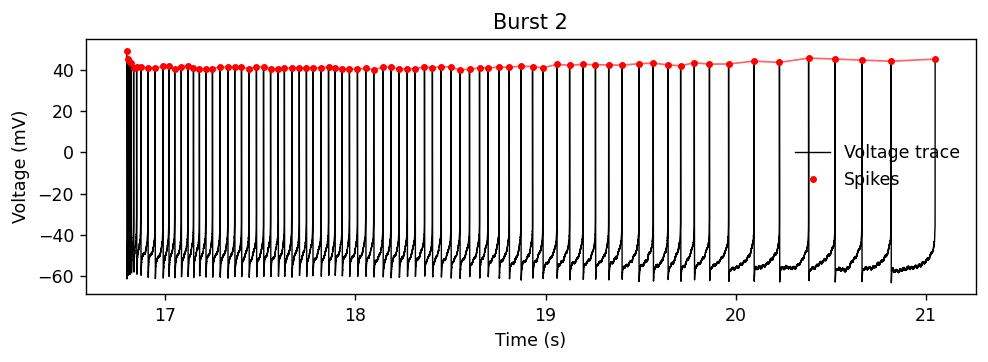

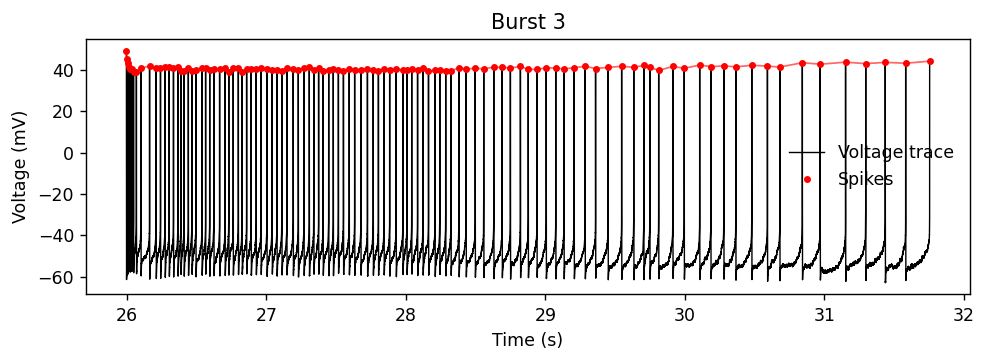

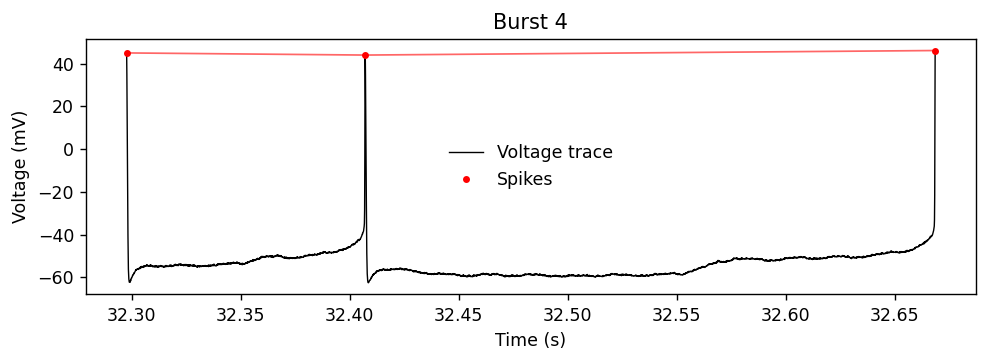

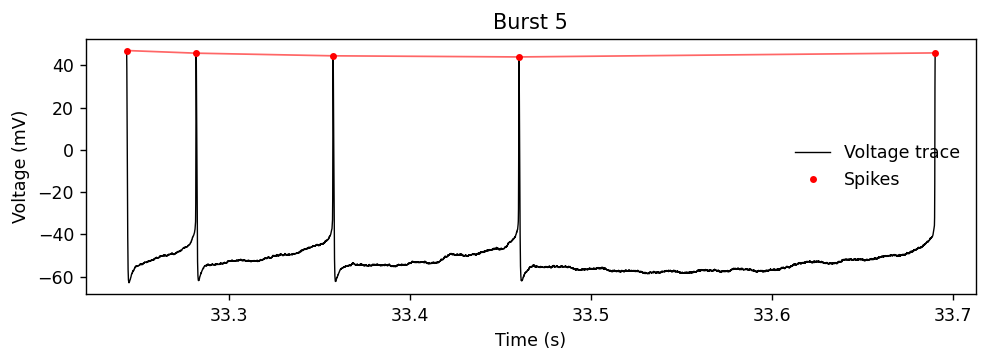

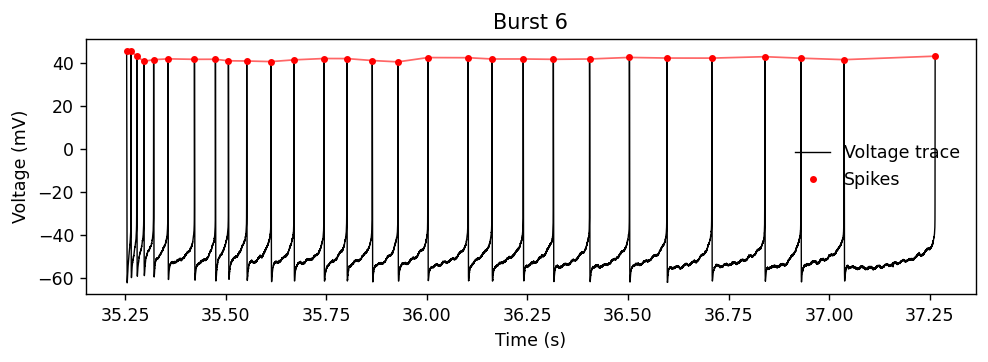

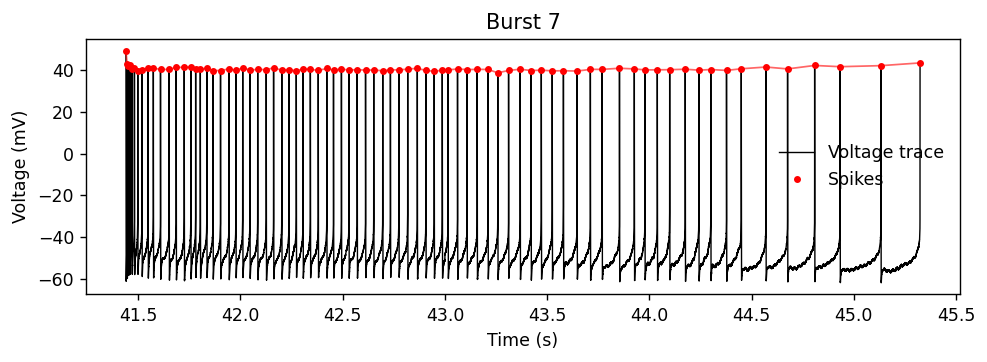

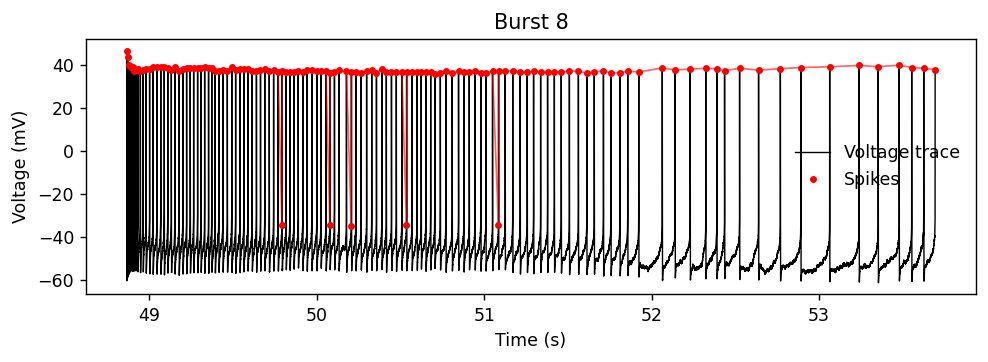

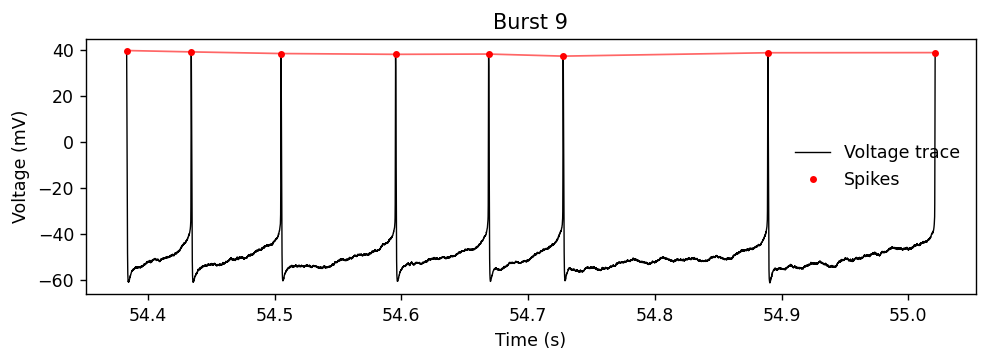

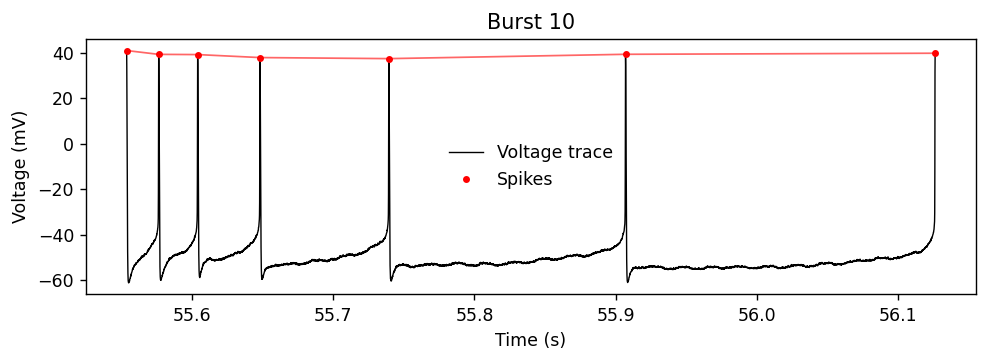

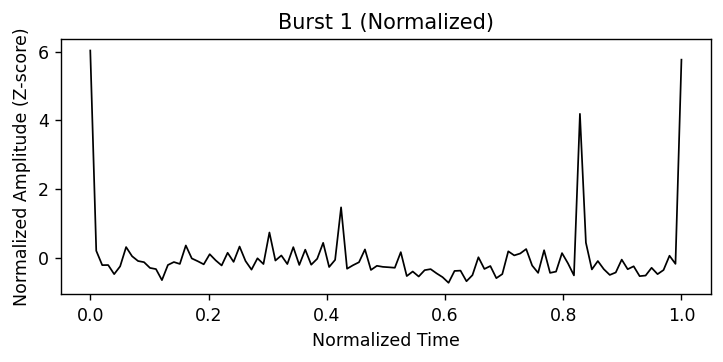

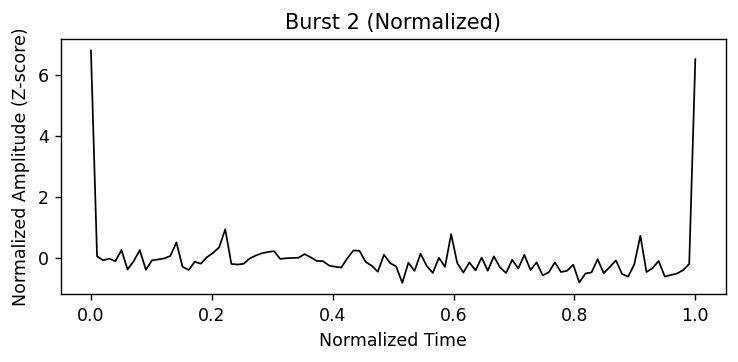

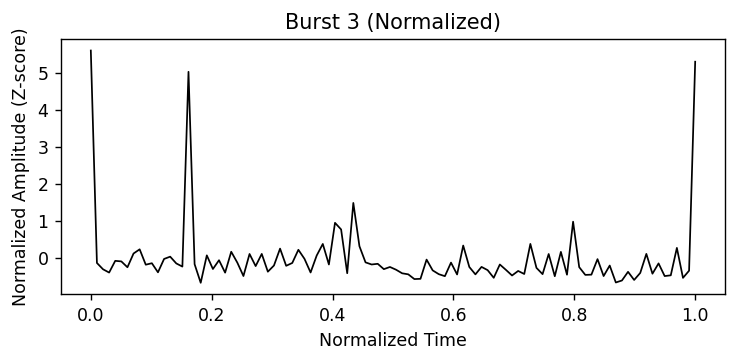

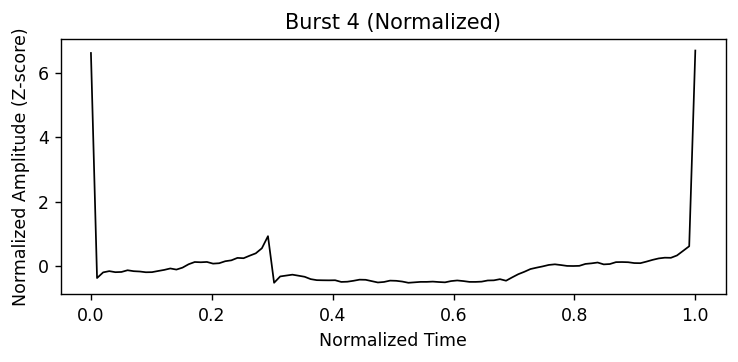

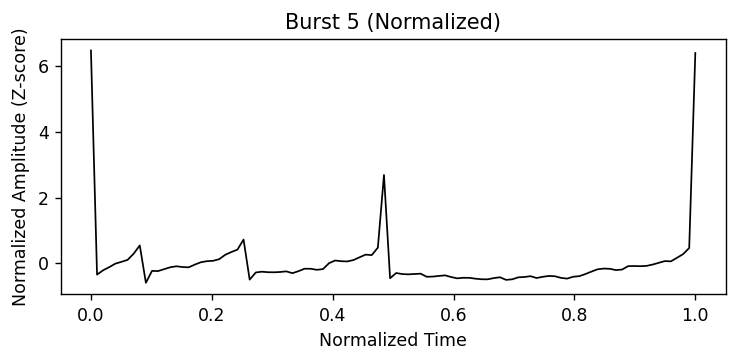

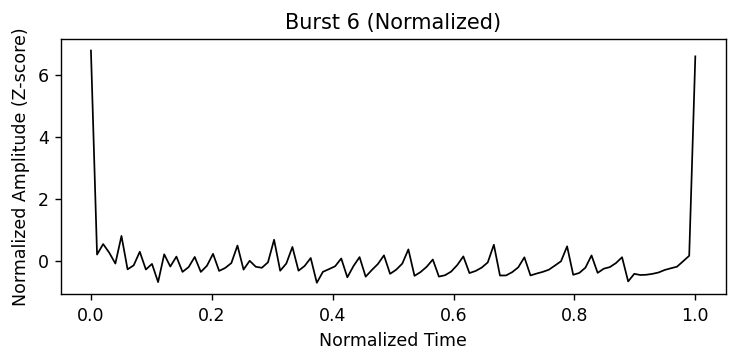

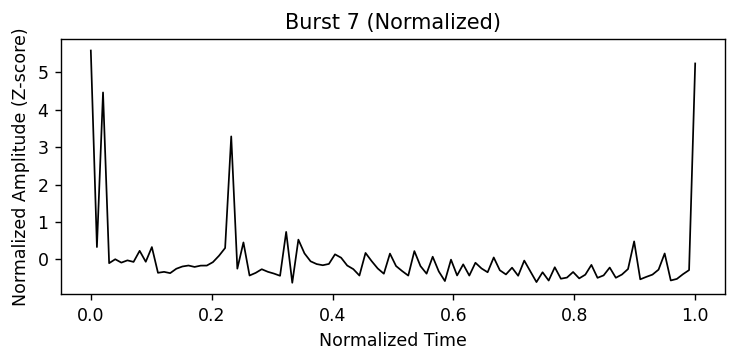

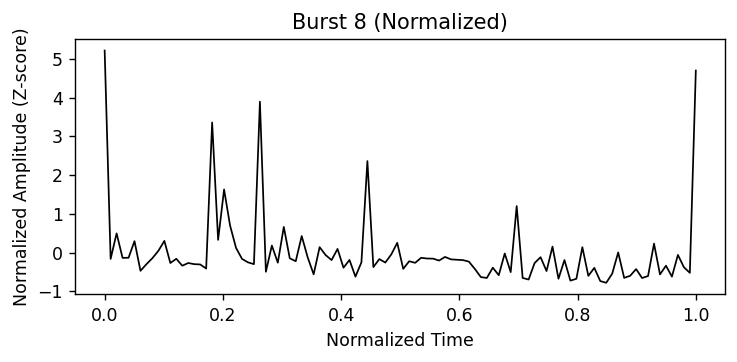

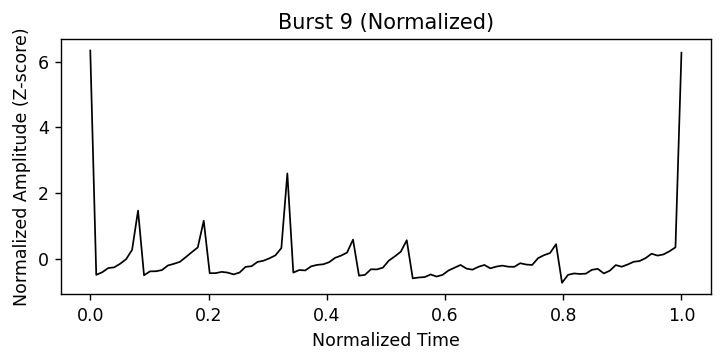

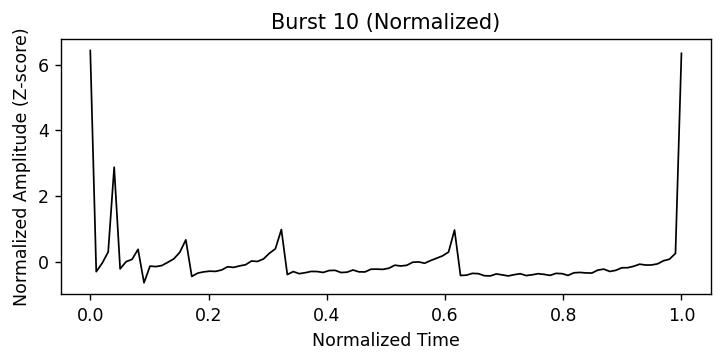

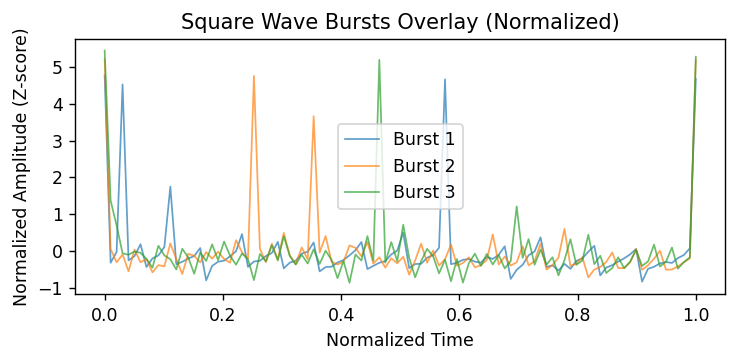

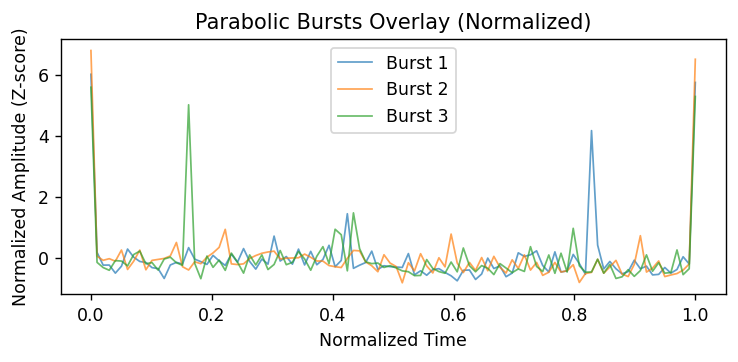

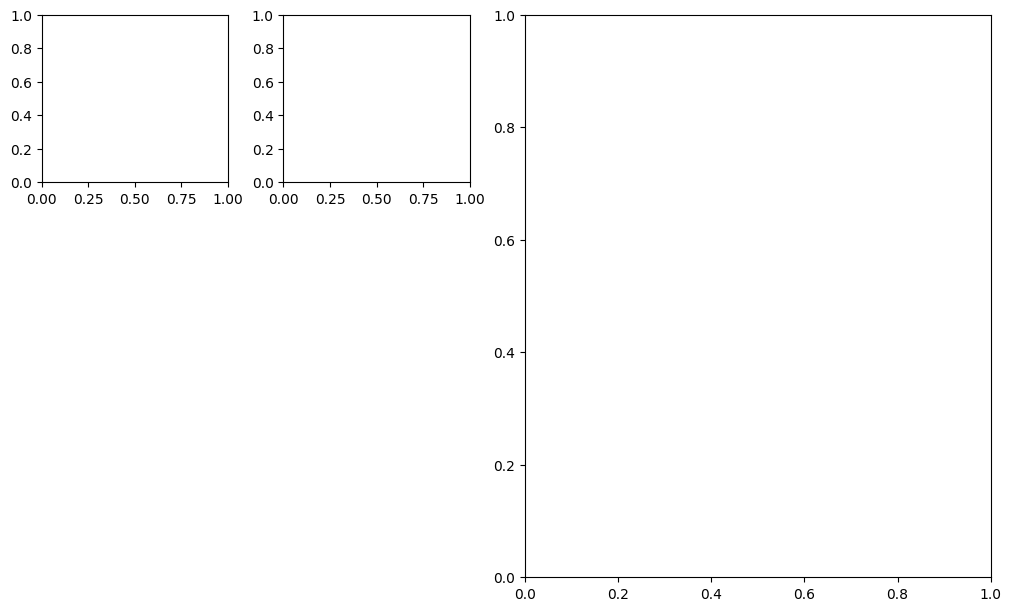

In [31]:
%matplotlib inline
viridis = cm.get_cmap('viridis', 4)

fig = plt.figure(constrained_layout=True, figsize=(10,6))
gs = fig.add_gridspec(3, 9)

fig_ax1 = fig.add_subplot(gs[0, :2])   # First shapelet
fig_ax2 = fig.add_subplot(gs[0, 2:4])  # Second shapelet
fig_ax4 = fig.add_subplot(gs[:, 4:])   # Distance-transformed 2D scatter plot

# %% [markdown]
# ## 📈 Plot Learned Shapelets
# 
# Each shapelet is a short subsequence learned to maximally separate the classes.

In [32]:
fig_ax1.plot(shp_clf.shapelets_[0].flatten())
fig_ax1.set_title('Shapelet $\\mathbf{s}_1$')

fig_ax2.plot(shp_clf.shapelets_[1].flatten())
fig_ax2.set_title('Shapelet $\\mathbf{s}_2$')

Text(0.5, 1.0, 'Shapelet $\\mathbf{s}_2$')

# %% [markdown]
# ## 🔹 Scatter Plot of Distance-Transformed Bursts
# 
# - Color-coded by class.  
# - X-axis: distance to shapelet 1.  
# - Y-axis: distance to shapelet 2.

In [33]:
for i, label in enumerate(np.unique(y)):
    mask = y == label
    fig_ax4.scatter(
        distances[mask][:,0],
        distances[mask][:,1],
        c=[viridis(i / max(1, len(np.unique(y)) - 1))]*np.sum(mask),
        edgecolors='k',
        label=f'Class {label}'
    )

# %% [markdown]
# ## 🧩 Decision Boundaries
# 
# Compute predicted class over a dense grid in the 2D shapelet space to visualize classifier boundaries.



In [34]:
# Grid for contour
xmin, xmax = distances[:,0].min()-0.1, distances[:,0].max()+0.1
ymin, ymax = distances[:,1].min()-0.1, distances[:,1].max()+0.1
xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 200),
    np.linspace(ymin, ymax, 200)
)

# Learned weights and biases
W, b = shp_clf.model_.get_layer("classification").get_weights()
n_classes = len(np.unique(y))

# Compute predictions over grid
Z = []
for x_val, y_val in np.c_[xx.ravel(), yy.ravel()]:
    if n_classes == 2:
        logit = b[0] + W[0,0]*x_val + W[1,0]*y_val
        pred = int(logit >= 0)
    else:
        scores = [b[i] + W[0,i]*x_val + W[1,i]*y_val for i in range(n_classes)]
        pred = np.argmax(scores)
    Z.append(pred)

Z = np.array(Z).reshape(xx.shape)
fig_ax4.contourf(xx, yy, Z/max(1, n_classes-1), cmap=viridis, alpha=0.25)

# %% [markdown]
# ## 🖌 Labels and Plot Aesthetics

fig_ax4.set_xlabel('$d(\\mathbf{x}, \\mathbf{s}_1)$')  # Distance to shapelet 1
fig_ax4.set_ylabel('$d(\\mathbf{x}, \\mathbf{s}_2)$')  # Distance to shapelet 2
fig_ax4.set_xlim(xmin, xmax)
fig_ax4.set_ylim(ymin, ymax)
fig_ax4.set_title('Distance-transformed bursts')
fig_ax4.legend()
plt.show()